# Linear Regression Modeling

In [1]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from matplotlib import dates

from sklearn.metrics import (classification_report, confusion_matrix, 
precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc)

In [2]:
# Load dataset and ceate pd dataframes
df = pd.read_csv('../DATA/data.csv')

In [3]:
df.describe().round(2)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00,170653.00
mean,0.53,1976.79,0.50,0.54,230948.31,0.48,0.08,0.17,5.20,0.21,-11.47,0.71,31.43,0.10,116.86
std,0.26,25.92,0.38,0.18,126118.41,0.27,0.28,0.31,3.52,0.17,5.70,0.46,21.83,0.16,30.71
min,0.00,1921.00,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00
25%,0.32,1956.00,0.10,0.42,169827.00,0.26,0.00,0.00,2.00,0.10,-14.62,0.00,11.00,0.03,93.42
50%,0.54,1977.00,0.52,0.55,207467.00,0.47,0.00,0.00,5.00,0.14,-10.58,1.00,33.00,0.04,114.73
75%,0.75,1999.00,0.89,0.67,262400.00,0.70,0.00,0.10,8.00,0.26,-7.18,1.00,48.00,0.08,135.54
max,1.00,2020.00,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51


In [4]:
df.shape

(170653, 19)

In [5]:
# Remove unnecessary columns
df = df.drop(labels = ['mode', 'explicit', 'id', 'duration_ms'], axis=1)
df.shape

(170653, 15)

## Distribution of popularity

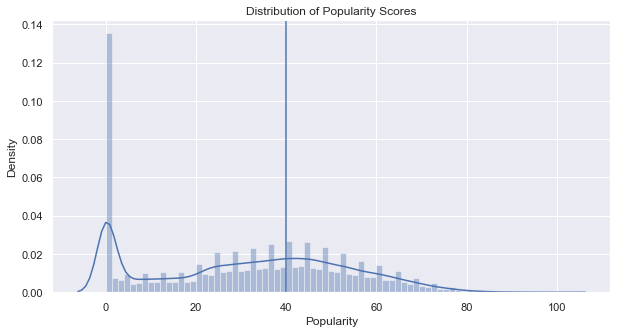

In [6]:
fig = plt.figure(figsize=(10,5))
sns.set(style="darkgrid") 
sns.distplot(df['popularity'], label="Popularity", bins='auto')
plt.xlabel("Popularity")
plt.ylabel("Density")
plt.title("Distribution of Popularity Scores")
plt.axvline(40)
plt.show()

## Model 1: With outliers
***

### Define X and y

In [7]:
X_cols = ['acousticness', 'danceability', 'energy', 
          'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'valence', 'tempo', 'key']

y_col = 'popularity'

In [8]:
X = df[X_cols]
y = list(df[y_col])

### Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [71]:
X_train

,const,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key
139898,1.0,-1.300454,-0.641233,0.866800,-0.532148,-0.648656,1.233650,-0.388204,-0.725574,1.793750,0.512720
47248,1.0,0.672219,-1.519915,-0.847390,-0.530949,-0.188803,-0.605297,-0.388204,-1.627983,-0.675455,0.228247
22420,1.0,1.294329,-1.406537,-1.246994,2.351395,-0.114541,-1.567829,-0.346786,-1.857569,-1.842496,-0.340699
30459,1.0,0.095306,0.027698,-0.246116,-0.532148,-0.594388,-0.271708,-0.426531,-0.566191,-0.460777,0.797193
98639,1.0,0.100623,0.481211,1.240262,-0.532148,-0.285915,0.052760,-0.197188,0.963123,1.537829,1.081666
...,...,...,...,...,...,...,...,...,...,...,...
158389,1.0,1.076325,0.010692,-0.358154,-0.532134,2.153303,0.205523,-0.440131,0.519129,-1.570853,-0.340699
153859,1.0,0.313310,-0.108356,1.781782,2.287599,-0.702353,0.678897,0.364736,-0.710394,1.069704,-1.478590
55484,1.0,-0.234359,1.359893,-1.385175,-0.532148,1.444959,-0.518480,1.465091,0.105493,0.749591,-0.340699
164327,1.0,-1.058522,1.053772,-0.163954,-0.531794,-0.661795,0.232007,-0.440749,0.234517,-0.754881,0.228247


### Scale data

In [10]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [11]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [12]:
X_train.shape, len(y_train)

((127989, 11), 127989)

### Instantiate OLS, Fit model

In [13]:
model = sm.OLS(y_train, X_train)
results = model.fit()

In [72]:
y_train

[52,
 38,
 0,
 46,
 28,
 32,
 2,
 39,
 58,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 68,
 0,
 15,
 15,
 44,
 38,
 57,
 57,
 44,
 64,
 42,
 46,
 13,
 27,
 28,
 0,
 59,
 44,
 23,
 36,
 68,
 45,
 0,
 3,
 0,
 8,
 0,
 0,
 52,
 31,
 55,
 0,
 7,
 0,
 34,
 56,
 0,
 1,
 36,
 25,
 31,
 66,
 48,
 49,
 53,
 29,
 0,
 52,
 19,
 0,
 0,
 0,
 36,
 38,
 38,
 44,
 66,
 67,
 44,
 0,
 9,
 26,
 41,
 43,
 24,
 0,
 48,
 24,
 58,
 58,
 31,
 41,
 28,
 54,
 0,
 5,
 0,
 59,
 39,
 42,
 0,
 38,
 48,
 50,
 62,
 28,
 22,
 26,
 0,
 0,
 54,
 46,
 42,
 46,
 0,
 25,
 37,
 1,
 0,
 52,
 71,
 50,
 24,
 58,
 17,
 26,
 30,
 49,
 14,
 44,
 64,
 52,
 45,
 55,
 54,
 58,
 27,
 14,
 62,
 40,
 0,
 3,
 0,
 52,
 32,
 48,
 58,
 0,
 46,
 73,
 32,
 57,
 35,
 79,
 46,
 58,
 3,
 0,
 64,
 33,
 74,
 24,
 31,
 58,
 1,
 67,
 45,
 26,
 0,
 12,
 52,
 8,
 63,
 9,
 19,
 10,
 31,
 48,
 64,
 60,
 57,
 11,
 21,
 23,
 38,
 54,
 23,
 0,
 0,
 53,
 0,
 42,
 0,
 2,
 36,
 28,
 39,
 0,
 30,
 45,
 68,
 5,
 0,
 38,
 30,
 23,
 27,
 20,
 42,
 10,
 0,
 0,
 25,
 76,
 46,
 0,

### Predict

In [14]:
fitted_vals = results.predict(X_train)

### Calculate residuals and plot

In [15]:
stu_resid = results.resid_pearson
residuals = results.resid
y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                           'stu_resid': stu_resid})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


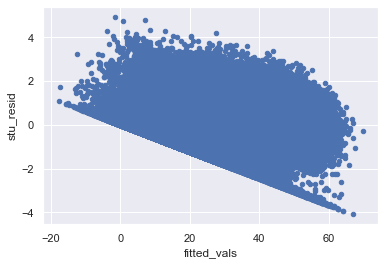

In [16]:
y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
plt.show()

### Get summary of results

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.004e+04
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:41:53   Log-Likelihood:            -5.3915e+05
No. Observations:              127989   AIC:                         1.078e+06
Df Residuals:                  127978   BIC:                         1.078e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.4407      0.046    688.414      0.000      31.351      31.530
acousticness        -8.6074      0.075   -115.083      0.000      -8.754      -8.461
danceability         4.2644      0.062     68.804      0.000       4.143       4.386
energy               2.7425      0.101     27.222      0.000       2.545       2.940
instrumentalness    -2.5943      0.053    -49.179      0.000      -2.698      -2.491
liveness            -1.3928      0.048    -29.218      0.000      -1.486      -1.299
loudness             1.7463      0.081     21.496      0.000       1.587       1.906
speechiness         -4.5709      0.050    -91.362      0.000      -4.669      -4.473
valence             -5.6024      0.061    -92.432      0.000      -5.721      -5.484
tempo                0.6744      0.048     14.046      0.000       0.580       0.769
key                  0.0238      0.046      0.522      0.602      -0.066       0.113
==============================================================================
Omnibus:                     3234.538   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3514.813
Skew:                           0.386   Prob(JB):                         0.00
Kurtosis:                       3.249   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**'key' column shows a p-value of 0.951 meaning it is not statistically significant**

### Create QQ Plot

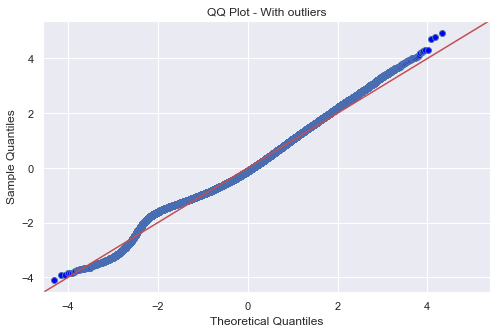

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("QQ Plot - With outliers")
fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
plt.show()

## Model 2: Removing outliers from X_train
***

### Define X and y

In [31]:
X_cols = ['acousticness', 'danceability', 'energy', 
          'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'valence', 'tempo', 'key']

y_col = 'popularity'

In [32]:
X = df[X_cols]
y = list(df[y_col])

### Train-test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Scale data

In [34]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [35]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Look at min and max values of features

In [36]:
X_train.describe().round(2).loc[['min', 'max']]

,const,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key
min,1.0,-1.34,-3.05,-1.80,-0.53,-1.18,-8.50,-0.61,-2.01,-3.81,-1.48
max,1.0,1.31,2.56,1.93,2.65,4.54,2.69,5.38,1.79,4.12,1.65


These min's and max's are on very different ranges. Let's try to make them into specific ranges.

### Make a new X_train df with only values between -3 and 3

In [41]:
X_train_clean = []

for col in X_train[X_cols]:
    X_train_clean = X_train[(X_train[col] >= -3) & (X_train[col] <= 3)]

In [43]:
X_train_clean.describe().round(2)

,const,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key
count,127989.0,127989.00,127989.00,127989.00,127989.00,127989.00,127989.00,127989.00,127989.00,127989.00,127989.00
mean,1.0,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00
std,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,1.0,-1.34,-3.05,-1.80,-0.53,-1.18,-8.50,-0.61,-2.01,-3.81,-1.48
25%,1.0,-1.07,-0.69,-0.85,-0.53,-0.61,-0.55,-0.39,-0.81,-0.77,-0.91
50%,1.0,0.04,0.06,-0.04,-0.53,-0.40,0.16,-0.33,0.04,-0.07,-0.06
75%,1.0,1.04,0.74,0.82,-0.21,0.31,0.75,-0.14,0.83,0.61,0.80
max,1.0,1.31,2.56,1.93,2.65,4.54,2.69,5.38,1.79,4.12,1.65


In [46]:
X_train_clean.shape, len(y_train)

((127989, 11), 127989)

### Instantiate OLS, fit model, predict, calculate residuals

In [48]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train_clean)
results = model.fit()

fitted_vals = results.predict(X_train_clean)

stu_resid = results.resid_pearson
residuals = results.resid
y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                           'stu_resid': stu_resid})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


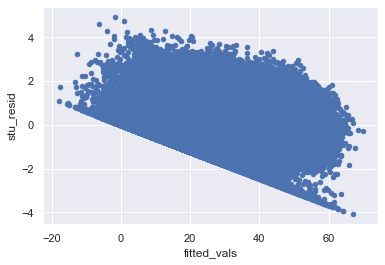

In [49]:
y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
plt.show()

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.002e+04
Date:                Fri, 05 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:01:24   Log-Likelihood:            -5.3920e+05
No. Observations:              127989   AIC:                         1.078e+06
Df Residuals:                  127978   BIC:                         1.079e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.4235      0.046    687.760      0.000      31.334      31.513
acousticness        -8.5687      0.075   -114.290      0.000      -8.716      -8.422
danceability         4.3113      0.062     69.605      0.000       4.190       4.433
energy               2.7729      0.101     27.493      0.000       2.575       2.971
instrumentalness    -2.6401      0.053    -50.005      0.000      -2.744      -2.537
liveness            -1.3926      0.048    -29.194      0.000      -1.486      -1.299
loudness             1.7036      0.081     20.995      0.000       1.545       1.863
speechiness         -4.5779      0.050    -91.553      0.000      -4.676      -4.480
valence             -5.6247      0.061    -92.896      0.000      -5.743      -5.506
tempo                0.7000      0.048     14.571      0.000       0.606       0.794
key                  0.0231      0.046      0.504      0.614      -0.067       0.113
==============================================================================
Omnibus:                     3184.888   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3452.950
Skew:                           0.384   Prob(JB):                         0.00
Kurtosis:                       3.239   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Create QQ Plot

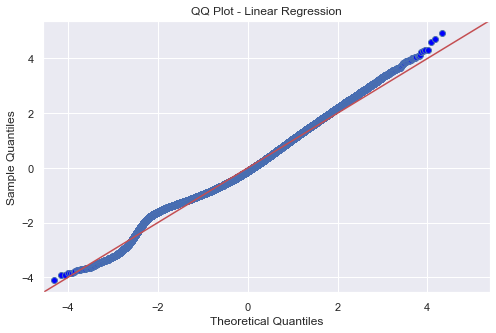

In [51]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("QQ Plot - Linear Regression")
fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
plt.show()

## Model 3: Removing outliers from X_train, X_test
***

### Define X and y

In [52]:
X_cols = ['acousticness', 'danceability', 'energy', 
          'instrumentalness', 'liveness', 'loudness', 
          'speechiness', 'valence', 'tempo', 'key']

y_col = 'popularity'

In [53]:
X = df[X_cols]
y = list(df[y_col])

### Train-test split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Scale data

In [55]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns,
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns,
                      index=X_test.index)

In [56]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Look at min and max values of features

In [57]:
X_train.describe().round(2).loc[['min', 'max']]

,const,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,key
min,1.0,-1.34,-3.04,-1.80,-0.53,-1.18,-8.51,-0.61,-2.00,-3.80,-1.48
max,1.0,1.31,2.56,1.93,2.66,4.53,2.67,5.39,1.79,4.12,1.65


In [63]:
pd.DataFrame(y_test).describe().round(2).loc[['min', 'max']]

,0
min,0.0
max,97.0


### Make a new X_train and X_test df with only values between -3 and 3